In [1]:
from pandas import read_csv, DataFrame,concat,notnull,isnull,Series
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from statsmodels.stats.anova import anova_lm
import numpy as np
from scipy.stats import gaussian_kde

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 29 days


In [2]:
%matplotlib inline

In [3]:
losses          =read_csv("all_economic_losses.csv")
vo              =read_csv("all_option_values.csv")
losses_wetlands =read_csv("all_losses_wetlands.csv")
vo_and_rp       =read_csv("all_vo_and_rp.csv")

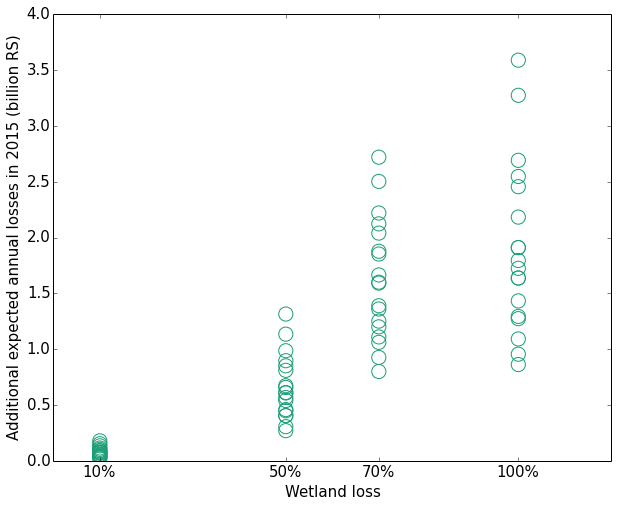

In [81]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(10,8))

ax=plt.subplot(111)

select = (losses.GDPgr==0)&(losses.Popgr==0)&(losses.urban_policy==0)&(losses.climate_change==0)
grouped = losses.ix[select,:].groupby("wetland_loss")

for i, (name, group) in enumerate(grouped):
    if i==0:
        continue
    plt.scatter([int(name)]*len(group.annuallosses),group.annuallosses-\
                losses.ix[select&(losses.wetland_loss==0),"annuallosses"].values,\
               marker='o',facecolors='none',edgecolors='#1b9e77',linewidth='1',s=200)
    
plt.xticks([10,50,70,100])
aa = ["{}%".format(i) for i in [10,50,70,100]]
ax.set_xticklabels(aa)

ax.set_ylim([0,4])

plt.ylabel('Additional expected annual losses in 2015 (billion RS)')
plt.xlabel('Wetland loss')

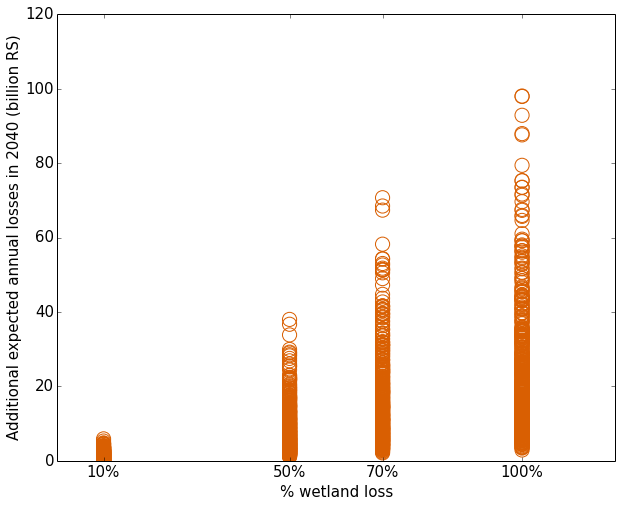

In [86]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(10,8))

ax=plt.subplot(111)

select2 = (losses.GDPgr>0)&(losses.Popgr>0)&(losses.urban_policy==0)&(losses.climate_change>0)
grouped2 = losses.ix[select2,:].groupby("wetland_loss")
for i, (name, group) in enumerate(grouped2):
    if i==0:
        continue
    plt.scatter([int(name)]*len(group.annuallosses),group.annuallosses\
                -losses.ix[select2&(losses.wetland_loss==0),"annuallosses"].values,\
               marker='o',facecolors='none',edgecolors='#d95f02',linewidth='1',s=200)
    
plt.xticks([10,50,70,100])
aa = ["{}%".format(i) for i in [10,50,70,100]]
ax.set_xticklabels(aa)

ax.set_ylim([0,120])

plt.ylabel('Additional expected annual losses in 2040 (billion RS)')
plt.xlabel('% wetland loss')

In [83]:
aa= group.annuallosses-losses.ix[select2&(losses.wetland_loss==0),"annuallosses"].values

In [85]:
aa.describe()

count    1080.000000
mean       15.716620
std        14.863037
min         0.862395
25%         5.453994
50%        10.495461
75%        20.826067
max        98.055067
dtype: float64

In [4]:
vo_and_rp.ix[vo_and_rp['wetland_loss']==0,:].mean()

wetland_loss    0.000000e+00
option_value    2.093198e+10
risk_premium    1.639660e+09
dtype: float64

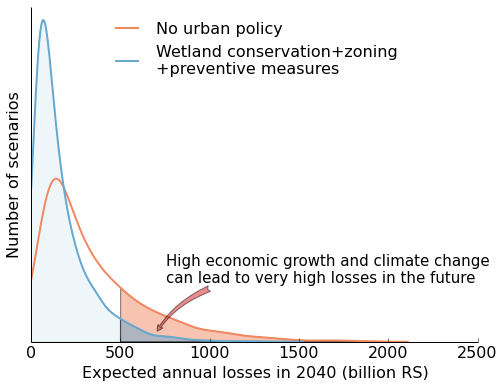

In [22]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
plt.figure(figsize=(8,6))
ax=plt.subplot(111)

select=(losses['urban_policy']==0)&(losses['losses_share']>0.2)&(losses['wetland_loss']>50)

density = gaussian_kde(losses.ix[select,'annuallosses'])
xs = np.linspace(0,max(losses['annuallosses']*1.1),num=300)

high_losses=xs>=500

density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs),linewidth=2,color='#ef8a62',label="No urban policy")

ax.fill_between(xs[high_losses], 0, density(xs[high_losses]),facecolor='#ef8a62',alpha=0.5)
plt.annotate('High economic growth and climate change\ncan lead to very high losses in the future', xy=(700, 0.3*density(700)),  xycoords='data',
                    xytext=(10, 50), textcoords='offset points',
                    size=15,
                    #bbox=dict(boxstyle="round", fc="0.8"),
                    arrowprops=dict(arrowstyle="fancy",
                                    fc='#d7191c', ec='black',
                                    alpha=0.5,
                                    patchB=None,
                                    connectionstyle="angle3,angleA=0,angleB=60"),
                        )

plt.xlabel('Expected annual losses in 2040 (billion RS)')
plt.ylabel('Number of scenarios')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('none')
ax.set_yticklabels([])

xs2 = np.linspace(0,max(losses.ix[~select,'annuallosses']),num=300)

density2 = gaussian_kde(losses.ix[~select,'annuallosses'])
density2.covariance_factor = lambda : .25
density2._compute_covariance()

plt.plot(xs2,density2(xs2),linewidth=2,color='#67a9cf',label="Wetland conservation+zoning\n+preventive measures")
ax.fill_between(xs[high_losses], 0, density2(xs[high_losses]),facecolor='#67a9cf',alpha=0.5)
ax.fill_between(xs[~high_losses], 0, density2(xs[~high_losses]),facecolor='#67a9cf',alpha=0.1)

ax.legend(bbox_to_anchor=[0.35,0.5,0.5,0.5],frameon=False,fontsize=16)

plt.savefig('distrib_annual_losses_urban_policy.png',bbox_inches="tight",dpi=300)

In [32]:
from scipy.interpolate import InterpolatedUnivariateSpline
def annual_losses(x):
    cost=x.ix[:,['return_period','costestimated']].copy()
    s = InterpolatedUnivariateSpline(cost['return_period'], cost['costestimated'], k=1)

    zerocost=DataFrame({'return_period':[100,10000],'costestimated':[s(100),s(100)]})
    cost=concat([zerocost,cost])
    cost.sort(columns='return_period', inplace=True)
    cost.index=range(len(cost))
    cost['costestimated']=cost['costestimated'].astype(float)
    cost['frequency']=1/cost['return_period']
    inte=0
    for i in range(1,len(cost)):
        trapeze =(cost.loc[i-1,'frequency']-cost.loc[i,'frequency'])*(cost.loc[i,'costestimated']+cost.loc[i-1,'costestimated'])/2
        inte += trapeze
    inte += cost.loc[len(cost)-1,'costestimated']*cost.loc[len(cost)-1,'frequency']
    return inte

In [29]:
current_costs=DataFrame(columns=['return_period','costestimated'])
current_costs.loc[len(current_costs),:]=[2,103]
current_costs.loc[len(current_costs),:]=[5,166]
current_costs.loc[len(current_costs),:]=[10,245]
current_costs.loc[len(current_costs),:]=[25,620]
current_costs.loc[len(current_costs),:]=[40,1388]
current_costs.loc[len(current_costs),:]=[50,1530]

In [30]:
current_costs

,return_period,costestimated
0,2,103
1,5,166
2,10,245
3,25,620
4,40,1388
5,50,1530


In [33]:
annual_losses(current_costs)

150.45499999999998